In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import eigvals
import matplotlib.pyplot as plt

Below is a simulation for the number of TA and FD cells in the crypt over time. Both reach a steady state as we would expect from the ODE model. There is randomness added via binomial distribution for decscision making.

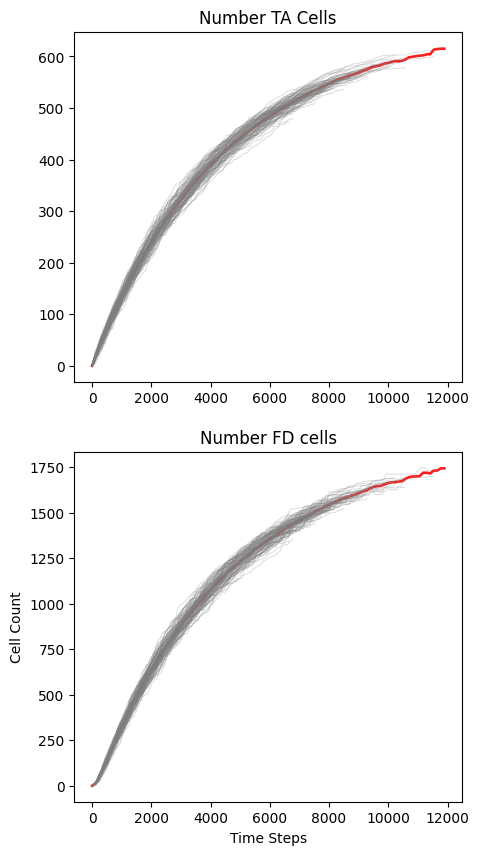

In [3]:

# Initialize variables

# Convert all rates to per hour
N0 = 18 # constant stem cell number
r = 1 / (2.5 * 24) # stem cell division rate (per hour)
lam = 1 / 30 # TA cell division rate (per hour)
d = 0.0338 # TA differentiation rate (per hour)
gamma = 1 / (3.5 * 24) # FD cell apoptosis rate (per hour)

steps = 1100   # Number of reactions per trajectory
cycles = 100   # Number of trajectories
T = np.zeros((cycles, steps + 1))  # Time array

mTA = np.zeros((cycles, steps + 1))  # Trajectory for m_TA
mFD = np.zeros((cycles, steps + 1))  # Trajectory for m_FD

# Store initial conditions (can be customized later)
mTA[:, 0] = 0  # Initial m_TA
mFD[:, 0] = 0  # Initial m_FD

# Main simulation loop
for i in range(cycles):
    for j in range(steps):
        # Calculate updated overall reaction rate based on ODE for mTA
        dmTA_dt = r * N0 + (lam - d) * mTA[i, j]
        dmFD_dt = d * mTA[i, j] - gamma * mFD[i, j]
        
        R = abs(dmTA_dt)  # Ensure reaction rate is positive

        # Calculate time to next reaction
        u1 = np.random.random()
        tau = 1 / R * np.log(1 / u1)

        # Store reaction time
        T[i, j + 1] = T[i, j] + tau

        # Select which reaction to occur
        u2 = np.random.random()
        if u2 < 0.5:  # Assign probability to modify m_TA
            mTA[i, j + 1] = mTA[i, j] + dmTA_dt * tau
            mFD[i, j + 1] = mFD[i, j]  # m_FD remains constant in this case

        else:  # Modify m_FD based on dmFD_dt
            mFD[i, j + 1] = mFD[i, j] + dmFD_dt * tau
            mTA[i, j + 1] = mTA[i, j]  # m_TA remains constant in this case

        mTA[i, j + 1] = max(0, mTA[i, j + 1])
        mFD[i, j + 1] = max(0, mFD[i, j + 1])

# # Calculate an average trajectory plot
ave_steps = 100
T_max = T.max()

# Set up average arrays
T_ave = np.linspace(0,T_max,ave_steps+1)
N_TA_ave = np.zeros(ave_steps+1)
N_FD_ave = np.zeros(ave_steps+1)

N_TA_ave[0] = 0
N_FD_ave[0] = 0

## Pass over average array entries
for i in range(1, ave_steps + 1):
    tmax = T_ave[i]
    TA_sum = 0
    FD_sum = 0
    t_count = 0

    # Pass over each trajectory and step therein
    for j in range(cycles):
        for k in range(steps):
            if T[j, k] <= tmax and T[j, k + 1] > tmax:
                t_count += 1
                TA_sum += mTA[j, k]
                FD_sum += mFD[j, k]

    # Calculate average - taking care if no samples observed
    if t_count == 0:
        N_TA_ave[i] = N_TA_ave[i - 1]
        N_FD_ave[i] = N_FD_ave[i - 1]
    else:
        N_TA_ave[i] = TA_sum / t_count
        N_FD_ave[i] = FD_sum / t_count

# ###### Plot Trajectories ######
fig, axs = plt.subplots(2, 1, figsize=(5,10))

# Plot average trajectories
axs[0].plot(T_ave, N_TA_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[0].set_title('Number TA Cells')
axs[1].plot(T_ave, N_FD_ave, marker='', color='red', linewidth=1.9, alpha=0.9)
axs[1].set_title('Number FD cells')

# Plot each simulated trajectory
for i in range(cycles):
    axs[0].plot(T[i,:], mTA[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    plt.xlabel("Time Steps")
    plt.ylabel("Cell Count")    
    axs[1].plot(T[i,:], mFD[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3)
    plt.xlabel("Time Steps")
    plt.ylabel("Cell Count")


plt.show()



Along with simulating the TA and FD cell populations, we were also intersested in seeing how changing the number of stem cells effected this growth. Below is the same gillespie simulation as above, except we've added an extra factor of varrying the number of stem cells. To do so, we simulate a random percentage between 2.5%-5% for the apoptosis and self-renewal rate, based on literature. We then use a binomial distribution to randomly generate the number of cells undergoing these changes. Another assumption we made in this case is that the apoptosis and self-renewal rate at any given timepoint were equal, assuming a realtivley stable colon crypt.

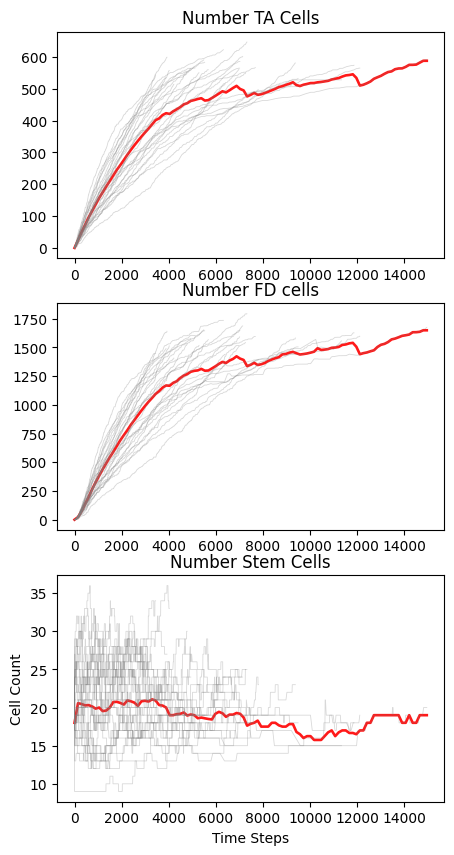

In [27]:

# Initialize variables

# Convert all rates to per hour
N_count = 18 # constant stem cell number
r = 1 / (2.5 * 24) # stem cell division rate (per hour)
lam = 1 / 30 # TA cell division rate (per hour)
d = 0.0338 # TA differentiation rate (per hour)
gamma = 1 / (3.5 * 24) # FD cell apoptosis rate (per hour)

steps = 1150  # Number of reactions per trajectory
cycles = 200   # Number of trajectories
T = np.zeros((cycles, steps + 1))  # Time array

mTA = np.zeros((cycles, steps + 1))  # Trajectory for m_TA
mFD = np.zeros((cycles, steps + 1))  # Trajectory for m_FD
Stem_Cell_Count = np.zeros((cycles, steps + 1))  # Trajectory for m_FD

# Store initial conditions (can be customized later)
mTA[:, 0] = 0  # Initial m_TA
mFD[:, 0] = 0  # Initial m_FD
Stem_Cell_Count[:, 0] = 18

def get_N(N_count):
    
    a = np.random.uniform(0.025, 0.05)

    # if N_count < 13 :
    #     N_post_birth = np.random.binomial(n = N_count, p = a)
    #     N_new = N_count + N_post_birth
    #     N_count = N_new

    #     return(N_new)
    # elif N_count > 23:
    #     N_post_death = np.random.binomial(n = N_count, p = a)
    #     N_new = N_count -N_post_death
    #     N_count = N_new

    #     return(N_new)
    #stochastically varries N0, this takes into account the births and deaths
    #of stem cells

    if N_count <= 1:
        return 1
    
    n_grow = np.random.randint(1, N_count)
    n_die = N_count - n_grow

    N_post_birth = np.random.binomial(n = n_grow, p = a)
    N_post_death = np.random.binomial(n = n_die, p = a)
   
    N_new = N_count + N_post_birth - N_post_death

    if N_new < 0:
        return(0)

    N_count = N_new
    

    return(N_new)


# Main simulation loop
for i in range(cycles):
    for j in range(steps):

        #generates possible change in Stem Cell Count
        p = np.random.random()
        if p < 0.1:
            N_count = get_N(Stem_Cell_Count[i, j])


        # Calculate updated overall reaction rate based on ODE for mTA
        dmTA_dt = r * N_count + (lam - d) * mTA[i, j]
        dmFD_dt = d * mTA[i, j] - gamma * mFD[i, j]
        
        R = abs(dmTA_dt)  # Ensure reaction rate is positive

        # Calculate time to next reaction
        u1 = np.random.random()
        tau = 1 / R * np.log(1 / u1)

        # Store reaction time
        T[i, j + 1] = T[i, j] + tau

        # Select which reaction to occur
        u2 = np.random.random()
        if u2 < 0.5:  # Assign probability to modify m_TA
            mTA[i, j + 1] = mTA[i, j] + dmTA_dt * tau
            mFD[i, j + 1] = mFD[i, j]  # m_FD remains constant in this case

        else:  # Modify m_FD based on dmFD_dt
            mFD[i, j + 1] = mFD[i, j] + dmFD_dt * tau
            mTA[i, j + 1] = mTA[i, j]  # m_TA remains constant in this case

        mTA[i, j + 1] = max(0, mTA[i, j + 1])
        mFD[i, j + 1] = max(0, mFD[i, j + 1])
        Stem_Cell_Count[i, j+1] = N_count

# Define filtering criteria
timestep_threshold = 15000
lower_bound = 1
upper_bound = 36

#Identify valid trajectories based on both conditions
valid_indices = [
    i for i in range(cycles)
    if (T[i, :].max() <= timestep_threshold and
        np.all(Stem_Cell_Count[i, :] >= lower_bound) and
        np.all(Stem_Cell_Count[i, :] <= upper_bound))
]

# Filter arrays to keep only valid trajectories
T = T[valid_indices, :]
mTA = mTA[valid_indices, :]
mFD = mFD[valid_indices, :]
Stem_Cell_Count = Stem_Cell_Count[valid_indices, :]


# # Calculate an average trajectory plot
ave_steps = 100
T_max = T.max()

# Set up average arrays
T_ave = np.linspace(0,T_max,ave_steps+1)
N_TA_ave = np.zeros(ave_steps+1)
N_FD_ave = np.zeros(ave_steps+1)
N_StemCell_ave = np.zeros(ave_steps+1)

N_TA_ave[0] = 0
N_FD_ave[0] = 0
N_StemCell_ave[0] = 18
## Pass over average array entries
for i in range(1, ave_steps + 1):
    tmax = T_ave[i]
    TA_sum = 0
    FD_sum = 0
    N_sum = 0
    t_count = 0

    # Pass over each trajectory and step therein
    for j in range(len(valid_indices)):  # Iterate only through valid trajectories
        for k in range(steps):
            if T[j, k] <= tmax and T[j, k + 1] > tmax:
                t_count += 1
                TA_sum += mTA[j, k]
                FD_sum += mFD[j, k]
                N_sum += Stem_Cell_Count[j,k]

    # Calculate average - taking care if no samples observed
    if t_count == 0:
        N_TA_ave[i] = N_TA_ave[i - 1]
        N_FD_ave[i] = N_FD_ave[i - 1]
        N_StemCell_ave[i] = N_StemCell_ave[i-1]
    else:
        N_TA_ave[i] = TA_sum / t_count
        N_FD_ave[i] = FD_sum / t_count
        N_StemCell_ave[i] = N_sum / t_count

# ###### Plot Trajectories ######
fig, axs = plt.subplots(3, 1, figsize=(5,10))

#t average trajectories 
axs[0].plot(T_ave, N_TA_ave, marker='', color='red', linewidth=1.9, alpha=0.9) 
axs[0].set_title('Number TA Cells') 
axs[1].plot(T_ave, N_FD_ave, marker='', color='red', linewidth=1.9, alpha=0.9) 
axs[1].set_title('Number FD cells') 
axs[2].plot(T_ave, N_StemCell_ave, marker='', color='red', linewidth=1.9, alpha=0.9) 
axs[2].set_title('Number Stem Cells')

#Plot each simulated trajectory
for i in range(len(valid_indices)): 
    axs[0].plot(T[i,:], mTA[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3) 
    plt.xlabel("Time Steps") 
    plt.ylabel("Cell Count")
    axs[1].plot(T[i,:], mFD[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3) 
    plt.xlabel("Time Steps") 
    plt.ylabel("Cell Count") 
    axs[2].plot(T[i,:], Stem_Cell_Count[i,:], marker='', color='grey', linewidth=0.6, alpha=0.3) 
    plt.xlabel("Time Steps") 
    plt.ylabel("Cell Count")

# axs[0].set_ylim(0, 1000)
# axs[1].set_ylim(0, 2000)

# axs[0].set_xlim(0, 12000)
# axs[1].set_xlim(0, 12000)
# axs[2].set_xlim(0, 12000)

plt.show()

